In [1]:
import pandas as pd
from json import load
import urllib.request, json 
from pandas.io.json import json_normalize
import seaborn as sns
import pylab as plt
import multiprocessing as mp
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from scipy import stats
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth',500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#https://github.com/gallantlab/pyrcca/blob/master/rcca.py

In [3]:
"""Python module for regularized kernel canonical correlation analysis"""

import h5py
import joblib
import numpy as np
from scipy.linalg import eigh


__copyright__ = 'Copyright 2016, UC Berkeley, Gallant lab.'


class _CCABase(object):
    def __init__(self, numCV=None, reg=None, regs=None, numCC=None,
                 numCCs=None, kernelcca=True, ktype=None, verbose=False,
                 select=0.2, cutoff=1e-15, gausigma=1.0, degree=2):
        self.numCV = numCV
        self.reg = reg
        self.regs = regs
        self.numCC = numCC
        self.numCCs = numCCs
        self.kernelcca = kernelcca
        self.ktype = ktype
        self.cutoff = cutoff
        self.select = select
        self.gausigma = gausigma
        self.degree = degree
        if self.kernelcca and self.ktype == None:
            self.ktype = 'linear'
        self.verbose = verbose

    def train(self, data):
        nT = data[0].shape[0]
        if self.verbose:
            print('Training CCA, kernel = %s, regularization = %0.4f, '
                  '%d components' % (self.ktype, self.reg, self.numCC))

        comps = kcca(data, self.reg, self.numCC, kernelcca=self.kernelcca,
                     ktype=self.ktype, gausigma=self.gausigma,
                     degree=self.degree)
        self.cancorrs, self.ws, self.comps = recon(data, comps,
                                                   kernelcca=self.kernelcca)
        if len(data) == 2:
            self.cancorrs = self.cancorrs[np.nonzero(self.cancorrs)]
        return self

    def validate(self, vdata):
        vdata = [np.nan_to_num(_zscore(d)) for d in vdata]
        if not hasattr(self, 'ws'):
            raise NameError('Algorithm has not been trained.')
        self.preds, self.corrs = predict(vdata, self.ws, self.cutoff)
        return self.corrs

    def compute_ev(self, vdata):
        nD = len(vdata)
        nT = vdata[0].shape[0]
        nC = self.ws[0].shape[1]
        nF = [d.shape[1] for d in vdata]
        self.ev = [np.zeros((nC, f)) for f in nF]
        for cc in range(nC):
            ccs = cc+1
            if self.verbose:
                print('Computing explained variance for component #%d' % ccs)
            preds, corrs = predict(vdata, [w[:, ccs-1:ccs] for w in self.ws],
                                   self.cutoff, zscore=False)
            resids = [d[0]-d[1] for d in zip(vdata, preds)]
            for s in range(nD):
                ev = (vdata[s].var(0) - resids[s].var(0))/vdata[s].var(0)
                ev[np.isnan(ev)] = 0.
                self.ev[s][cc] = ev
        return self.ev

    def save(self, filename):
        h5 = h5py.File(filename, 'a')
        for key, value in self.__dict__.items():
            if value is not None:
                if isinstance(value, list):
                    for di in range(len(value)):
                        grpname = 'dataset%d' % di
                        dgrp = h5.require_group(grpname)
                        try:
                            dgrp.create_dataset(key, data=value[di])
                        except RuntimeError:
                            del h5[grpname][key]
                            dgrp.create_dataset(key, data=value[di])
                else:
                    h5.attrs[key] = value
        h5.close()

    def load(self, filename):
        h5 = h5py.File(filename, 'a')
        for key, value in h5.attrs.items():
            setattr(self, key, value)
        for di in range(len(h5.keys())):
            ds = 'dataset%d' % di
            for key, value in h5[ds].items():
                if di == 0:
                    setattr(self, key, [])
                self.__getattribute__(key).append(value.value)


class CCACrossValidate(_CCABase):
    """
    Attributes:
        numCV (int): number of cross-validation folds
        regs (list or numpy.array): regularization param array.
                                   Default: np.logspace(-3, 1, 10)
        numCCs (list or numpy.array): list of numbers of canonical dimensions
                                     to keep. Default is np.range(5, 10).
        kernelcca (bool): kernel or non-kernel CCA. Default is True.
        ktype (string): type of kernel used if kernelcca is True.
                        Value can be 'linear' (default) or 'gaussian'.
        verbose (bool): default is True.
    Returns:
        ws (list): canonical weights
        comps (list): canonical components
        cancorrs (list): correlations of the canonical components
                         on the training dataset
        corrs (list): correlations on the validation dataset
        preds (list): predictions on the validation dataset
        ev (list): explained variance for each canonical dimension
    """

    def __init__(self, numCV=None, regs=None, numCCs=None, kernelcca=True,
                 ktype=None, verbose=True, select=0.2, cutoff=1e-15,
                 gausigma=1.0, degree=2):
        numCV = 10 if numCV is None else numCV
        regs = np.array(np.logspace(-3, 1, 10)) if regs is None else regs
        numCCs = np.arange(5, 10) if numCCs is None else numCCs
        super(CCACrossValidate, self).__init__(numCV=numCV, regs=regs,
                                               numCCs=numCCs,
                                               kernelcca=kernelcca,
                                               ktype=ktype, verbose=verbose,
                                               select=select, cutoff=cutoff,
                                               gausigma=gausigma,
                                               degree=degree)

    def train(self, data, parallel=True):
        """
        Train CCA with cross-validation for a set of regularization
        coefficients and/or numbers of CCs
        Attributes:
            data (list): training data matrices
                         (number of samples X number of features).
                         Number of samples must match across datasets.
            parallel (bool): use joblib to train cross-validation folds
                             in parallel
        """
        nT = data[0].shape[0]
        chunklen = 10 if nT > 50 else 1
        nchunks = int(0.2 * nT / chunklen)
        indchunks = list(zip(*[iter(range(nT))] * chunklen))
        corr_mat = np.zeros((len(self.regs), len(self.numCCs)))
        selection = max(int(self.select * min([d.shape[1] for d in data])), 1)
        for ri, reg in enumerate(self.regs):
            for ci, numCC in enumerate(self.numCCs):
                running_corr_mean_sum = 0.
                if parallel:
                    fold_corr_means = joblib.Parallel(n_jobs=self.numCV)(
                        joblib.delayed(train_cvfold)(
                            data=data, reg=reg, numCC=numCC,
                            kernelcca=self.kernelcca, ktype=self.ktype,
                            gausigma=self.gausigma, degree=self.degree,
                            cutoff=self.cutoff, selection=selection)
                        for fold in range(self.numCV))
                    running_corr_mean_sum += sum(fold_corr_means)
                else:
                    for cvfold in range(self.numCV):
                        fold_corr_mean = train_cvfold(
                            data=data, reg=reg, numCC=numCC,
                            kernelcca=self.kernelcca, ktype=self.ktype,
                            gausigma=self.gausigma, degree=self.degree,
                            cutoff=self.cutoff, selection=selection)
                        running_corr_mean_sum += fold_corr_mean

                corr_mat[ri, ci] = running_corr_mean_sum / self.numCV
        best_ri, best_ci = np.where(corr_mat == corr_mat.max())
        self.best_reg = self.regs[best_ri[0]]
        self.best_numCC = self.numCCs[best_ci[0]]

        comps = kcca(data, self.best_reg, self.best_numCC,
                     kernelcca=self.kernelcca, ktype=self.ktype,
                     gausigma=self.gausigma, degree=self.degree)
        self.cancorrs, self.ws, self.comps = recon(data, comps,
                                                   kernelcca=self.kernelcca)
        if len(data) == 2:
            self.cancorrs = self.cancorrs[np.nonzero(self.cancorrs)]
        return self

def train_cvfold(data, reg, numCC, kernelcca, ktype, gausigma, degree,
                 cutoff, selection):
    """
    Train a cross-validation fold of CCA
    """
    nT = data[0].shape[0]
    chunklen = 10 if nT > 50 else 1
    nchunks = int(0.2 * nT / chunklen)
    indchunks = list(zip(*[iter(range(nT))] * chunklen))
    np.random.shuffle(indchunks)
    heldinds = [ind for chunk in indchunks[:nchunks]
                for ind in chunk]
    notheldinds = list(set(range(nT)) - set(heldinds))
    comps = kcca([d[notheldinds] for d in data], reg, numCC,
                 kernelcca=kernelcca, ktype=ktype,
                 gausigma=gausigma, degree=degree)
    cancorrs, ws, ccomps = recon([d[notheldinds] for d in data], comps,
                                 kernelcca=kernelcca)
    preds, corrs = predict([d[heldinds] for d in data], ws, cutoff=cutoff)
    fold_corr_mean = []
    for corr in corrs:
        corr_idx = np.argsort(corr)[::-1]
        corr_mean = corr[corr_idx][:selection].mean()
        fold_corr_mean.append(corr_mean)
    return np.mean(fold_corr_mean)


class CCA(_CCABase):
    """Attributes:
        reg (float): regularization parameter. Default is 0.1.
        numCC (int): number of canonical dimensions to keep. Default is 10.
        kernelcca (bool): kernel or non-kernel CCA. Default is True.
        ktype (string): type of kernel used if kernelcca is True.
                        Value can be 'linear' (default) or 'gaussian'.
        verbose (bool): default is True.
    Returns:
        ws (list): canonical weights
        comps (list): canonical components
        cancorrs (list): correlations of the canonical components
                         on the training dataset
        corrs (list): correlations on the validation dataset
        preds (list): predictions on the validation dataset
        ev (list): explained variance for each canonical dimension
    """
    def __init__(self, reg=0., numCC=10, kernelcca=True, ktype=None,
                 verbose=True, cutoff=1e-15):
        super(CCA, self).__init__(reg=reg, numCC=numCC, kernelcca=kernelcca,
                                  ktype=ktype, verbose=verbose, cutoff=cutoff)

    def train(self, data):
        return super(CCA, self).train(data)


def predict(vdata, ws, cutoff=1e-15, zscore=True):
    """Get predictions for each dataset based on the other datasets
    and weights. Find correlations with actual dataset."""
    iws = [np.linalg.pinv(w.T, rcond=cutoff) for w in ws]
    ccomp = _listdot([d.T for d in vdata], ws)
    ccomp = np.array(ccomp)
    preds = []
    corrs = []

    for dnum in range(len(vdata)):
        idx = np.ones((len(vdata),))
        idx[dnum] = False
        proj = ccomp[idx > 0].mean(0)
        pred = np.dot(iws[dnum], proj.T).T
        zpred = np.nan_to_num(_zscore(pred))
        if zscore:
            preds.append(np.nan_to_num(zpred))
        else:
            preds.append(np.nan_to_num(pred))
        cs = np.nan_to_num(_rowcorr(vdata[dnum].T, zpred.T))
        corrs.append(cs)
    return preds, corrs


def kcca(data, reg=0., numCC=None, kernelcca=True, ktype='linear',
         gausigma=1.0, degree=2):
    """Set up and solve the kernel CCA eigenproblem
    """
    if kernelcca:
        kernel = [_make_kernel(d, ktype=ktype, gausigma=gausigma,
                               degree=degree) for d in data]
    else:
        kernel = [d.T for d in data]

    nDs = len(kernel)
    nFs = [k.shape[0] for k in kernel]
    numCC = min([k.shape[1] for k in kernel]) if numCC is None else numCC

    # Get the auto- and cross-covariance matrices
    crosscovs = [np.dot(ki, kj.T) for ki in kernel for kj in kernel]

    # Allocate left-hand side (LH) and right-hand side (RH):
    LH = np.zeros((sum(nFs), sum(nFs)))
    RH = np.zeros((sum(nFs), sum(nFs)))

    # Fill the left and right sides of the eigenvalue problem
    for i in range(nDs):
        RH[sum(nFs[:i]) : sum(nFs[:i+1]),
           sum(nFs[:i]) : sum(nFs[:i+1])] = (crosscovs[i * (nDs + 1)]
                                             + reg * np.eye(nFs[i]))

        for j in range(nDs):
            if i != j:
                LH[sum(nFs[:j]) : sum(nFs[:j+1]),
                   sum(nFs[:i]) : sum(nFs[:i+1])] = crosscovs[nDs * j + i]

    LH = (LH + LH.T) / 2.
    RH = (RH + RH.T) / 2.

    maxCC = LH.shape[0]
    r, Vs = eigh(LH, RH, eigvals=(maxCC - numCC, maxCC - 1))
    r[np.isnan(r)] = 0
    rindex = np.argsort(r)[::-1]
    comp = []
    Vs = Vs[:, rindex]
    for i in range(nDs):
        comp.append(Vs[sum(nFs[:i]):sum(nFs[:i + 1]), :numCC])
    return comp


def recon(data, comp, corronly=False, kernelcca=True):
    nT = data[0].shape[0]
    # Get canonical variates and CCs
    if kernelcca:
        ws = _listdot(data, comp)
    else:
        ws = comp
    ccomp = _listdot([d.T for d in data], ws)
    corrs = _listcorr(ccomp)
    if corronly:
        return corrs
    else:
        return corrs, ws, ccomp

def _zscore(d): return (d - d.mean(0)) / d.std(0)


def _demean(d): return d - d.mean(0)


def _listdot(d1, d2): return [np.dot(x[0].T, x[1]) for x in zip(d1, d2)]


def _listcorr(a):
    """Returns pairwise row correlations for all items in array as a list of matrices
    """
    corrs = np.zeros((a[0].shape[1], len(a), len(a)))
    for i in range(len(a)):
        for j in range(len(a)):
            if j > i:
                corrs[:, i, j] = [np.nan_to_num(np.corrcoef(ai, aj)[0, 1])
                                  for (ai, aj) in zip(a[i].T, a[j].T)]
    return corrs


def _rowcorr(a, b):
    """Correlations between corresponding matrix rows"""
    cs = np.zeros((a.shape[0]))
    for idx in range(a.shape[0]):
        cs[idx] = np.corrcoef(a[idx], b[idx])[0, 1]
    return cs


def _make_kernel(d, normalize=True, ktype='linear', gausigma=1.0, degree=2):
    """Makes a kernel for data d
      If ktype is 'linear', the kernel is a linear inner product
      If ktype is 'gaussian', the kernel is a Gaussian kernel, sigma = gausigma
      If ktype is 'poly', the kernel is a polynomial kernel with degree=degree
    """
    d = np.nan_to_num(d)
    cd = _demean(d)
    if ktype == 'linear':
        kernel = np.dot(cd, cd.T)
    elif ktype == 'gaussian':
        from scipy.spatial.distance import pdist, squareform
        pairwise_dists = squareform(pdist(d, 'euclidean'))
        kernel = np.exp(-pairwise_dists ** 2 / 2 * gausigma ** 2)
    elif ktype == 'poly':
        kernel = np.dot(cd, cd.T) ** degree
    kernel = (kernel + kernel.T) / 2.
    if normalize:
        kernel = kernel / np.linalg.eigvalsh(kernel).max()
    return kernel

In [4]:
def find_correlated(X, X_names):
    duplicated_columns = np.where(np.triu(np.corrcoef(X.T) > 0.99, k=1))
    to_drop = np.unique(duplicated_columns[1])
    return to_drop

def drop_correlated(X, X_names, to_drop):
    X_dropped = np.delete(X, to_drop, axis=1)
    X_names_dropped = np.delete(X_names, to_drop)
    return X_dropped, X_names_dropped

def find_linear_dependence(M, M_names):
    # adapted from (https://stackoverflow.com/a/43774637)
    M = M.copy().T
    LI_names=[M_names[0]]
    LI=[M[0]]
    to_drop=[]
    for i in range(1, M.shape[0]):
        tmp=[]
        for r in LI:
            tmp.append(r)
        tmp.append(M[i])                #set tmp=LI+[M[i]]
        if np.linalg.matrix_rank(tmp)>len(LI):    #test if M[i] is linearly independent from all (row) vectors in LI
            LI.append(M[i])             #note that matrix_rank does not need to take in a square matrix
        else:
            to_drop.append(i)                    
    return np.array(to_drop)

In [5]:
df_t1w_unique = pd.read_csv('t1w_datalad_and_mriqc.csv', low_memory=False)
df_bold_unique = pd.read_csv('bold_datalad_and_mriqc.csv', low_memory=False)

In [6]:
res_df = df_t1w_unique

In [7]:
(df_t1w_unique.notnull().sum()/df_t1w_unique.shape[0]).sort_values(ascending=False)

summary_csf_mad                                                    1.000000
summary_bg_mad                                                     1.000000
summary_csf_k                                                      1.000000
summary_bg_stdv                                                    1.000000
summary_bg_p95                                                     1.000000
summary_bg_p05                                                     1.000000
summary_bg_n                                                       1.000000
summary_bg_median                                                  1.000000
summary_bg_mean                                                    1.000000
summary_bg_k                                                       1.000000
snr_total                                                          1.000000
spacing_z                                                          1.000000
spacing_y                                                          1.000000
spacing_x   

In [52]:
df_bold_unique.groupby(['bids_meta.Manufacturer','dataset', 'bids_meta.MagneticFieldStrength'])[['provenance.md5sum']].count()

provenance.md5sum
bids_meta.Manufacturer dataset   bids_meta.MagneticFieldStrength                   
GE                     nndsp     3.0                                           1168
                       openneuro 1.0                                            252
                                 3.0                                            518
Philips                openfmri  3.0                                            116
                       openneuro 3.0                                            697
Siemens                cmi       3.0                                           2014
                       openfmri  3.0                                            674
                       openneuro 1.0                                             14
                                 3.0                                           3302

In [63]:
res_df.loc[res_df['bids_meta.MagneticFieldStrength'] == 2, ['bids_meta.MagneticFieldStrength', 'bids_meta.Manufacturer', 'bids_meta.ManufacturersModelName', 'bids_meta.InstitutionName', 'bids_meta.InstitutionAddress']]

,bids_meta.MagneticFieldStrength,bids_meta.Manufacturer,bids_meta.ManufacturersModelName,bids_meta.InstitutionName,bids_meta.InstitutionAddress
13194,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore_.9C8EF0.Exp.15-May-2006_MD_212
13195,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore_.9C8EF0.Exp.15-May-2006_MD_212
13196,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore_.BC55F0.Exp.16-May-2007_MD_212
13197,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore_.3865F2.Exp01-Sep-2005_MD_2122
13198,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore_.48E5EB.Exp10-Sep-2004_MD_2122
13199,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore_.3865F2.Exp01-Sep-2005_MD_2122
13200,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore_.581370._MD_21224_USA
13201,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore_MD_21224_USA
13202,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore_.48E5EB.Exp10SEP04_MD_21224_US
13203,2.0,Siemens,Allegra,NIDA,5500Nathan_Shock_Drive_Baltimore.BC58F0.Exp.16-May-2008_MD_2122


In [61]:
res_df.groupby([ 'bids_meta.MagneticFieldStrength', 'bids_meta.Manufacturer', 'bids_meta.ManufacturersModelName', 'bids_meta.InstitutionName', 'bids_meta.InstitutionAddress'])[['provenance.md5sum']].count()

provenance.md5sum
bids_meta.MagneticFieldStrength bids_meta.Manufacturer bids_meta.ManufacturersModelName bids_meta.InstitutionName                     bids_meta.InstitutionAddress                                                      
1.0                             Siemens                Avanto                           Center_of_Neurology                           Volokolamskoye_shosse_80_Moscow_2CAF25_Moscow_RU_ZIP                             1
                                                                                        University_College                            Bedford_Way_26_London_London_GB_WC1H_0AP                                         3
2.0                             Siemens                Allegra                          NIDA                                          251Bayview_Blvd_RM_B1A739_Baltimore_MD_21224_USA                                 3
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore.1C0669.Exp._MD_21224_USA                        6
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore.BC58F0.Exp.16-May-2008_MD_2122                  3
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore.F25C69.Exp._MD_21224_USA                       10
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_.3865F2.Exp01-Sep-2005_MD_2122                 18
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_.48E5EB.Exp10-Sep-2004_MD_2122                 15
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_.48E5EB.Exp10SEP04_MD_21224_US                  8
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_.48E5EB._MD_21224_USA                           2
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_.581370._MD_21224_USA                           1
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_.9C8EF0.Exp.15-May-2006_MD_212                 25
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_.BC55F0.Exp.16-May-2007_MD_212                 23
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_.BC58F0.Exp.16-May-2007_MD_212                  2
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_.BC58F0.Exp.16-May-2008_MD_212                  7
                                                                                                                                      5500Nathan_Shock_Drive_Baltimore_MD_21224_USA                                   11
3.0                             Philips                Achieva dStream                  Leibniz_Institut_Magdeburg                    Magdeburg                                                                       22
                                                                            

In [50]:

res_df.groupby(['bids_meta.ConversionSoftware', 'bids_meta.ConversionSoftwareVersion'])[['provenance.md5sum']].count()

provenance.md5sum
bids_meta.ConversionSoftware bids_meta.ConversionSoftwareVersion                                    
dcm2niix                     v1.0.20170130                                                        43
                             v1.0.20170207                                                       368
                             v1.0.20170207 (openJPEG build)                                        2
                             v1.0.20170403 (OpenJPEG build) GCC4.8.4                               2
                             v1.0.20170411 GCC4.3.2                                               19
                             v1.0.20170411 GCC4.4.7                                              880
                             v1.0.20170411 GCC5.4.0                                               60
                             v1.0.20170528 GCC5.4.0                                              262
                             v1.0.20170621 (OpenJPEG build) GCC4.4.7                               9
                             v1.0.20170621 GCC4.9.2                                                4
                             v1.0.20170624 (OpenJPEG build) Clang8.1.0                             1
                             v1.0.20170624 (OpenJPEG build) MSC1900                               35
                             v1.0.20170624 GCC5.3.1                                                2
                             v1.0.20170624 GCC5.4.0                                                1
                             v1.0.20170624 GCC6.3.0                                               57
                             v1.0.20170724 (OpenJPEG build) GCC6.1.0                             444
                             v1.0.20170724 Clang7.0.2                                             51
                             v1.0.20170724 GCC4.4.7                                              327
                             v1.0.20170821 (OpenJPEG build) GCC5.3.1                              29
                             v1.0.20170821 GCC4.4.7                                              128
                             v1.0.20170821 GCC4.8.4                                               85
                             v1.0.20170821 GCC4.9.2                                                9
                             v1.0.20170923 (OpenJPEG build) GCC4.4.7                              41
                             v1.0.20170923 (OpenJPEG build) GCC4.8.4                               1
                             v1.0.20170923 (OpenJPEG build) GCC6.3.0                               7
                             v1.0.20170923 Clang9.0.0                                              1
                             v1.0.20171017 (OpenJPEG build) GCC4.8.4                              75
                             v1.0.20171017 GCC4.4.7                                                1
                             v1.0.20171017 GCC4.8.4                                              146
                             v1.0.20171017 GCC6.3.0                                             8677
                             v1.0.20171021 (JasPer build) GCC4.8.5                                51
                             v1.0.20171021 GCC5.3.1                                                1
                             v1.0.20171103 (OpenJPEG build) GCC5.3.1                              49
                             v1.0.20171103 (OpenJPEG build) GCC6.3.0                             196
                             v1.0.20171103 Clang9.0.0                                             24
                             v1.0.20171204 (OpenJPEG build) GCC4.8.4                             408
                             v1.0.20171215 (OpenJPEG build) Clang8.1.0                            93
                             v1.0.20171215 (OpenJPEG build) Clang9.0.0                             1
                             v1.0.20171215 

In [ ]:
# allegra might be really different
# 

In [35]:
res_df.groupby(['bids_meta.Manufacturer', 'bids_meta.PulseSequenceDetails'])[['provenance.md5sum']].count()

provenance.md5sum
bids_meta.Manufacturer bids_meta.PulseSequenceDetails                                       
Siemens                %CustomerSeq%_Andre_tfl_mgh_multiecho                             140
                       %CustomerSeq%_WIP711_Moco_tfl_multiecho_epinav_711                  4
                       %CustomerSeq%_tfl_ADNI                                           1366
                       %CustomerSeq%_tfl_mgh_epinav_ABCD                                 270
                       %CustomerSeq%_tfl_mgh_multiecho                                    15
                       %CustomerSeq%_tfl_wip900D_VE11C                                    24
                       %SiemensSeq%_tfl                                                15679

In [48]:
!ls -lth

total 4.0G
-rw-r--r-- 1 nielsond users 1016K Jan  3 12:58 mriqc_cca.ipynb
-rw-r--r-- 1 nielsond users   26K Jan  3 10:55 MRIQC_preproc_and_merge.ipynb
-rw-r--r-- 1 nielsond users   14M Jan  2 15:26 MRIQC_TSNE_run_and_plot.ipynb
-rw-r--r-- 1 nielsond users  341M Jan  2 14:48 bold_datalad_and_mriqc.csv
-rw-r--r-- 1 nielsond users  1.7M Jan  2 14:47 t2w_datalad_and_mriqc.csv
-rw-r--r-- 1 nielsond users  125M Jan  2 14:47 t1w_datalad_and_mriqc.csv
-rw-r--r-- 1 nielsond users   12K Dec 26 16:15 get_datalad_data.ipynb
-rw-r--r-- 1 nielsond users  307M Dec 26 16:15 datalad_metadata.csv
-rw-r--r-- 1 nielsond users   43K Dec 26 15:39 MRIQC_slow_download.ipynb
-rw-r--r-- 1 nielsond users  3.6K Dec 26 15:34 JSON_to_csv.ipynb
-rw-r--r-- 1 nielsond users  1.5G Dec 26 15:33 all_t1s_2018_12_26.csv
-rw-r--r-- 1 nielsond users  7.5K Dec 26 14:45 Untitled-Copy1.ipynb
-rw-r--r-- 1 nielsond users  176M Dec 26 14:20 all_bolds_2018_12_26.csv
-rw-r--r-- 1 nielsond users  1.7M Dec 26 12:52 all_t2s_2018_12_26.

In [32]:
res_df.groupby(['bids_meta.Manufacturer', 'bids_meta.ScanningSequence', 'bids_meta.SequenceVariant', 'bids_meta.ProtocolName'])[['provenance.md5sum']].count()

provenance.md5sum
bids_meta.Manufacturer bids_meta.ScanningSequence bids_meta.SequenceVariant bids_meta.ProtocolName                                                 
GE                     GR                         SS_SK                     3D_volume_Bravo                                                      85
                                                                            Ax_FSPGR_BRAVO                                                        5
                                                                            SAG_BRAVO_FA_12_BW_31.25                                              4
                                                                            STRUC_BRAVO_SAG3D_ARC_.9mm                                            1
                                                                            SagT1Bravo_09mm                                                       3
                                                                            SagT1_BRAVO                                                           2
                                                                            Sag_FSPGR_BRAVO                                                      54
                                                                            T1w_.8mm_sag                                                          1
                                                                            ax_3D_t1                                                              2
                                                                            sag_FSPGR_BRAVO                                                      15
                                                  SS_SP_SK                  ACCELERATED_SAG_IR-SPGR                                               2
                                                                            AX_FSPGR_3D_8_900                                                    58
                                                                            Accelerated_SAG_IR-FSPGR                                             46
                                                                            Accelerated_SAG_IR-SPGR                                             312
                                                                            Accelerated_Sag_IR-FSPGR                                            218
                                                                            Accelerated_Sag_IR-SPGR                                             152
                                                                            Accelerated_Sagittal_IR-FSPGR                                        22
                                                                            Axial_FSPGR_3D                                                       79
                                                                            IR-FSPGR                                                             91
                                                                            IR-FSPGR-Repeat                                                      82
                                                                            IR-FSPGR_REPEAT                                                      19
                                                                            IR-SPGR                                                              34
                                                                            IR-SPGR_w_acceleration                                               34
                                                                            PU:SAG_FSPGR_3D_.9X.9X.9                                             21
                                                                            SAG_FSPGR_3D_8_900                                                   37
                                                                            SAG_IR-FSPGR                                              

In [28]:
df_bold_unique.groupby(['bids_meta.Manufacturer', 'bids_meta.ScanningSequence', 'bids_meta.SequenceVariant', 'bids_meta.ProtocolName'])[['provenance.md5sum']].count()

provenance.md5sum
bids_meta.Manufacturer bids_meta.ScanningSequence bids_meta.SequenceVariant bids_meta.ProtocolName                                                  
GE                     EP_GR                      SS                        Audition_fmri                                                        360
                                                                            Audition_fmri_-_4_runs                                               232
                                                                            fMRI                                                                 435
                                                                            fMRI_120_CONNECTIVITY                                                 16
                                                                            fMRI_ADDT                                                             16
                                                                            fMRI_Mental_Rotation                                                  15
                                                                            finger_run1                                                            1
                                                                            finger_run2                                                            1
                                                                            images_run_1                                                           1
                                                                            images_run_2                                                           1
                                                                            images_run_3                                                           1
                                                                            rest_assetEPI                                                        143
                                                                            rest_fMRI_close                                                        4
                                                                            rest_fMRI_open                                                         4
                                                                            resting_func                                                          15
                                                                            resting_state                                                          4
                                                                            rod_1                                                                  1
                                                                            rod_2                                                                  1
                                                                            rod_3                                                                  1
                                                                            stim_1                                                                 1
                                                                            stim_2                                                                 1
                       EP_RM                      NONE                      Audition_fmri_-_4_runs                                                67
                                                                            AxEPI_GoNoGo                                                           1
                                                                            AxEPI_NBack                                                            1
                                                                            AxEPI_RestingState1                                                    1
                                                                            AxEPI_RestingState2             

In [22]:
xs = ['bids_meta.PulseSequenceType', 'bids_meta.ScanningSequence',
      'bids_meta.SequenceVariant', 'bids_meta.ScanOptions',
      'bids_meta.PulseSequenceDetails', 'bids_meta.SoftwareVersions']
for x in xs:
    print(f"Field: {x}, counts:{res_df[x].notnull().sum()}")
    print(res_df[x].str.upper().unique() )
    print()

Field: bids_meta.PulseSequenceType, counts:485
[nan 'AX FSPGR BRAVO' 'MPRAGE' 'EPI' 'T1W SENSE' '3D-FSPGR WITH SENSE'
 'SPGR']

Field: bids_meta.ScanningSequence, counts:30010
['RM' 'GR/IR' 'GR_IR' 'IR_GR' 'GR' 'GR\\IR' 'MPRAGE' nan '3D SPGR'
 '3D TFL' '3D TFE' 'IR-FSPGR' 'SCANNING SEQUENCE' 'FSPGR'
 'T1 TURBO FIELD ECHO' 'T1TFE' 'IRSPGR']

Field: bids_meta.SequenceVariant, counts:27350
['NONE' 'SP/MP' 'SK_SP_MP' 'SP_MP' 'SK_SP_MP_OSP' 'SP_MP_OSP' 'SS_SK' 'MP'
 'SS_SP_SK' 'OTHER' 'SP\\MP' 'SP' 'SK\\SP\\MP' 'SP_OSP' nan 'SS_SP_SK_OSP'
 'SS\\SK' 'SS/SP/SK' 'TFL3D1_NS']

Field: bids_meta.ScanOptions, counts:24502
['ACC_GEMS' 'ACC_GEMS_PFF' 'FILTERED_GEMS_ACC_GEMS' 'NONE' 'IR' 'IR_WE'
 'FAST_GEMS_EDR_GEMS_ACC_GEMS' 'FAST_GEMS_EDR_GEMS_FILTERED_GEMS_ACC_GEMS'
 'OTHER' 'EDR_GEMS' 'VB_GEMS_EDR_GEMS' 'FAST_GEMS_EDR_GEMS_FILTERED_GEMS'
 'EDR_GEMS_FILTERED_GEMS' 'FAST_GEMS_EDR_GEMS'
 'FAST_GEMS_EDR_GEMS_FILTERED_GEMS_ACC_GEMS_IR_GEMS' nan
 'FAST_GEMS_EDR_GEMS_ACC_GEMS_FILTERED_GEMS'
 'EDR_GEMS_P

In [18]:
#based on http://mriquestions.com/commercial-acronyms.html
sequence_dict = {'RF-Spoiled GRE': ((res_df['bids_meta.ProtocolName'].str.upper().str.contains('FLASH'))
                               | (res_df['bids_meta.ProtocolName'].str.upper().str.contains('SPGR'))
                               | (res_df['bids_meta.ProtocolName'].str.upper().str.contains('FFE'))),
              'Ultrafast GRE': ((res_df['bids_meta.ProtocolName'].str.upper().str.contains('RAGE'))
                                | (res_df['bids_meta.ProtocolName'].str.upper().str.contains('MPR'))
                                | (res_df['bids_meta.ProtocolName'].str.upper().str.contains('BRAVO'))
                                | (res_df['bids_meta.ProtocolName'].str.upper().str.contains('TFE')))}
ssq_dict = {'RF-Spoiled GRE': ((res_df['bids_meta.ScanningSequence'] == 'IRSPGR')
                                  | (res_df['bids_meta.ScanningSequence'] == '3D SPGR')
                                  | (res_df['bids_meta.ScanningSequence'] == 'IR-FSPGR')),
             'Ultrafast GRE': ((res_df['bids_meta.ScanningSequence'] == 'MPRAGE')
                                  | (res_df['bids_meta.ScanningSequence'] == 'T1 turbo field echo')
                                  | (res_df['bids_meta.ScanningSequence'] == '3D TFE')) }

In [19]:
res_df['clean_sequence_name'] = np.nan
for name,ind in sequence_dict.items():
    res_df.loc[ind,'clean_sequence_name'] = name
for name,ind in ssq_dict.items():
    res_df.loc[ind,'clean_sequence_name'] = name

In [21]:
res_df.clean_sequence_name.notnull().sum()

29410

In [190]:
#cp_coil is single channel reference: https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.20925
coil_dict = {8: (res_df['bids_meta.ReceiveCoilName'].str.contains('8')
                & res_df['bids_meta.ReceiveCoilName'].notnull()),
             12: ((res_df['bids_meta.ReceiveCoilName'].str.contains('12')
                  | res_df['bids_meta.ReceiveCoilName'].str.contains('HeadMatrix'))
                 & res_df['bids_meta.ReceiveCoilName'].notnull()),
             16: (res_df['bids_meta.ReceiveCoilName'].str.contains('16')
                 & res_df['bids_meta.ReceiveCoilName'].notnull()),
             20: (res_df['bids_meta.ReceiveCoilName'].str.contains('20')
                 & res_df['bids_meta.ReceiveCoilName'].notnull()),
             32: (res_df['bids_meta.ReceiveCoilName'].str.contains('32')
                 & res_df['bids_meta.ReceiveCoilName'].notnull()),
             64: (res_df['bids_meta.ReceiveCoilName'].str.contains('64')
                 & res_df['bids_meta.ReceiveCoilName'].notnull()),
             1: (res_df['bids_meta.ReceiveCoilName'].str.contains('CP')
                & res_df['bids_meta.ReceiveCoilName'].notnull())}
for name,ind in coil_dict.items():
    res_df.loc[ind,'clean_receive_channels'] = name

In [191]:
t1_metric_cols = np.array(['cjv',  'cnr',  'efc',  'fber',  'fwhm_avg',  'fwhm_x',
                  'fwhm_y',  'fwhm_z',  'icvs_csf',  'icvs_gm',  'icvs_wm',  'inu_med',
                  'inu_range',  'qi_1',  'qi_2',  'rpve_csf',  'rpve_gm',  'rpve_wm',  'size_x',
                  'size_y',  'size_z',  'snr_csf',  'snr_gm',  'snr_total',  'snr_wm',
                  'snrd_csf',  'snrd_gm',  'snrd_total',  'snrd_wm',  'spacing_x',  'spacing_y',
                  'spacing_z',  'summary_bg_k',  'summary_bg_mad',  'summary_bg_mean',
                  'summary_bg_median',  'summary_bg_n',  'summary_bg_p05',  'summary_bg_p95',
                  'summary_bg_stdv',  'summary_csf_k',  'summary_csf_mad',  'summary_csf_mean',
                  'summary_csf_median',  'summary_csf_n',  'summary_csf_p05',  'summary_csf_p95',
                  'summary_csf_stdv',  'summary_gm_k',  'summary_gm_mad',  'summary_gm_mean',
                  'summary_gm_median',  'summary_gm_n',  'summary_gm_p05',  'summary_gm_p95',
                  'summary_gm_stdv',  'summary_wm_k',  'summary_wm_mad',  'summary_wm_mean',
                  'summary_wm_median',  'summary_wm_n',  'summary_wm_p05',  'summary_wm_p95',
                  'summary_wm_stdv',  'tpm_overlap_csf',  'tpm_overlap_gm',  'tpm_overlap_wm',
                  'wm2max'])

t1_metric_cols = np.array(['cjv',  'cnr',  'efc',  'fber',  'fwhm_avg',  'fwhm_x',
                  'fwhm_y',  'fwhm_z',  'icvs_csf',  'icvs_gm',  'icvs_wm',  'inu_med',
                  'inu_range',  'qi_1',  'qi_2',  'rpve_csf',  'rpve_gm',  'rpve_wm',  'snr_csf',  'snr_gm',  'snr_total',  'snr_wm',
                  'snrd_csf',  'snrd_gm',  'snrd_total',  'snrd_wm', 'tpm_overlap_csf',  'tpm_overlap_gm',  'tpm_overlap_wm',
                  'wm2max'])

bold_mt = pd.read_csv('./BOLD_metric_table.csv').rename(columns={'Good or Bad':'good', 'Name':'metric'})
t1w_mt = pd.read_csv('./T1w_metric_table.csv').rename(columns={'Good or Bad':'good', 'Name':'metric'})

In [192]:
neg_cols = []
good_cols = []

for v in t1w_mt.iterrows():
    if v[1][1]==-1.0:
        cname = v[1][0]
        new_name = 'neg_' + cname
        #print(new_name)
        neg_cols.append(new_name)
        res_df[new_name] = -res_df[cname]
    if v[1][1]==1.0:
        good_cols.append(v[1][0])
        
neg_cols = np.array(neg_cols)
good_cols = np.array(good_cols)
y_cols = np.concatenate((good_cols, neg_cols))
y_cols

array(['cnr', 'fber', 'snr_csf', 'snr_gm', 'snr_total', 'snr_wm',
       'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm', 'tpm_overlap_csf',
       'tpm_overlap_gm', 'tpm_overlap_wm', 'neg_cjv', 'neg_efc',
       'neg_fwhm_avg', 'neg_fwhm_x', 'neg_fwhm_y', 'neg_fwhm_z',
       'neg_qi_1', 'neg_qi_2', 'neg_rpve_csf', 'neg_rpve_gm',
       'neg_rpve_wm', 'neg_summary_bg_stdv'], dtype='<U19')

In [193]:
res_df.loc[:,['bids_meta.EchoTime','bids_meta.RepetitionTime',  'bids_meta.FlipAngle', 'bids_meta.InversionTime','bids_meta.PixelBandwidth']].describe()

,bids_meta.EchoTime,bids_meta.RepetitionTime,bids_meta.FlipAngle,bids_meta.InversionTime,bids_meta.PixelBandwidth
count,34761.000000,34697.000000,33774.000000,26983.000000,25489.000000
mean,0.013514,1.664042,10.436105,1.097564,207.476674
std,0.138847,1.207754,4.243121,11.602116,77.679800
min,0.001276,0.002500,4.000000,0.000000,20.000000
25%,0.002830,0.009120,8.000000,0.780000,180.000000
50%,0.003012,2.200000,9.000000,0.900000,200.000000
75%,0.003300,2.300000,13.000000,0.900000,240.000000
max,1.896000,7.600000,90.000000,900.000000,994.000000


In [194]:
cont_vars = ['bids_meta.FlipAngle', 'bids_meta.RepetitionTime', 'bids_meta.EchoTime','clean_receive_channels']
cat_pipe = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False)),
                          ('ss', StandardScaler())])
x_mappers = [('rs', StandardScaler(), cont_vars)]
x_tf = ColumnTransformer(x_mappers)

In [312]:
# Shuffle res_df to break any dependence in row order
res_df=res_df.sample(frac=1, random_state=10103)

In [313]:
cleaned_df = res_df
res_df = res_df.loc[res_df['bids_meta.Manufacturer']=='Siemens', :]

In [314]:
res_df.shape

(23520, 512)

In [315]:
ho_frac = 0.3

In [316]:
# There's code here for subselecting only manufacturers that have at least 100 records

notnull_ind = (res_df.loc[:, cont_vars].isnull().sum(1)==0)
print(f"{notnull_ind.sum()} scans have values for all variables.")

17472 scans have values for all variables.


In [317]:
nonnull_df = res_df.loc[notnull_ind, :]

In [318]:
ho_n = int(len(nonnull_df) * ho_frac)
ho_n

5241

In [319]:
ho_df = nonnull_df.iloc[:ho_n, :].reset_index(drop=True)
w_df = nonnull_df.iloc[ho_n:, :].reset_index(drop=True)

In [320]:
X = x_tf.fit_transform(nonnull_df.loc[notnull_ind, :])
X_names = np.array(cont_vars)
X_to_drop = find_linear_dependence(X, X_names)
if len(X_to_drop > 0):
    print(f"These columns in X will be dropped because they are linear combinations of other columns:{X_names[X_to_drop]}")

In [321]:
X_names

array(['bids_meta.FlipAngle', 'bids_meta.RepetitionTime',
       'bids_meta.EchoTime', 'clean_receive_channels'], dtype='<U24')

In [322]:
X_to_drop

array([], dtype=float64)

In [323]:
hoX = x_tf.fit_transform(ho_df)
hoX_names = np.array(cont_vars)
assert (hoX_names == X_names).all()
#hoX, hoX_names = drop_correlated(hoX, hoX_names, X_to_drop)
assert np.linalg.matrix_rank(hoX) == hoX.shape[1]

wX = x_tf.fit_transform(w_df)
wX_names = np.array(cont_vars)
assert (wX_names == X_names).all()
#wX, wX_names = drop_correlated(wX, wX_names, X_to_drop)
assert np.linalg.matrix_rank(wX) == wX.shape[1]

In [324]:

y_mappers = [('rs', StandardScaler(), y_cols)]
y_tf = ColumnTransformer(y_mappers)
Y = y_tf.fit_transform(nonnull_df)
Y_names= y_cols
Y_to_drop = find_linear_dependence(Y, Y_names)
print(f"These columns in Y will be dropped because they are linear combinations of other columns:{Y_names[Y_to_drop]}")


These columns in Y will be dropped because they are linear combinations of other columns:['snr_wm' 'snrd_wm' 'neg_fwhm_z']


In [325]:
hoY = y_tf.fit_transform(ho_df)
hoY_names = y_cols
assert (hoY_names == Y_names).all()
hoY, hoY_names = drop_correlated(hoY, hoY_names, Y_to_drop)
assert np.linalg.matrix_rank(hoY) == hoY.shape[1]

wY = y_tf.fit_transform(w_df)
wY_names = y_cols
assert (wY_names == Y_names).all()
wY, wY_names = drop_correlated(wY, wY_names, Y_to_drop)
assert np.linalg.matrix_rank(wY) == wY.shape[1]

In [326]:
pd.DataFrame(hoX, columns=hoX_names).to_csv('heldout_X.csv', index=False)
pd.DataFrame(hoY, columns=hoY_names).to_csv('heldout_Y.csv', index=False)
pd.DataFrame(wX, columns=wX_names).to_csv('working_X.csv', index=False)
pd.DataFrame(wY, columns=wY_names).to_csv('working_Y.csv', index=False)

In [327]:
wX.shape, wY.shape, hoX.shape, hoY.shape

((12231, 4), (12231, 22), (5241, 4), (5241, 22))

In [398]:
ccaCV = CCACrossValidate(kernelcca=False,
                         numCCs = np.arange(1,wX.shape[1]),
                         regs = [0., 10, 90, 1e2, 105, 110, 120, 1e4, 1e6],
                         numCV=50,
                         select=0.001,
                         cutoff=1e-30)

In [399]:
# ccaCV = CCA(kernelcca=False,
#                          numCC = 4,
#                          reg = 10)
# ccaCV.train([wX,wY])


In [400]:
ccaCV.train([wX,wY], parallel=True)
print(f"Best regularization factor: {ccaCV.best_reg}")
print(f"Best number of components: {ccaCV.best_numCC}")

Best regularization factor: 100.0
Best number of components: 3


In [401]:
hoX_pred, hoY_pred = ccaCV.validate([hoX,hoY])


In [402]:
hoX_ev, hoY_ev = ccaCV.compute_ev([hoX,hoY])

Computing explained variance for component #1
Computing explained variance for component #2
Computing explained variance for component #3


In [403]:
w_df.shape

(12231, 512)

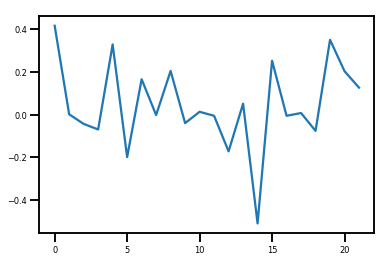

In [404]:
plt.plot(hoY_ev[0])

In [405]:
x_weights = ccaCV.ws[0]
y_weights = ccaCV.ws[1]
x_projected = np.matmul( hoX, x_weights)
y_projected = np.matmul( hoY, y_weights)

In [406]:
x_weights

array([[-6.44577541e-03, -3.58644732e-04, -2.56010135e-03],
       [ 3.34602394e-05,  3.43450864e-03, -5.70155104e-03],
       [-5.86495401e-05, -8.36636703e-04,  1.89308638e-03],
       [-2.86279510e-04, -4.65433466e-03, -5.10092677e-03]])

In [407]:
y_weights

array([[ 1.78655935e-03, -4.64511817e-03,  7.21711338e-03],
       [ 2.24702372e-05, -4.62179899e-05, -4.83645417e-05],
       [-1.19155814e-03, -6.55026228e-04, -3.40210352e-05],
       [-4.23210803e-04,  1.60007924e-04, -7.71016260e-06],
       [ 2.37461356e-03,  2.03964184e-03, -4.04622713e-04],
       [-1.06584622e-03, -1.39431885e-04,  5.07645672e-03],
       [ 1.37497636e-03, -1.08171395e-03, -2.34174419e-03],
       [-1.10130576e-05, -9.81114095e-04, -6.45441012e-03],
       [-1.70821018e-03, -2.57364493e-03,  1.40125017e-03],
       [ 2.61018711e-04, -1.10138710e-03,  6.55789225e-04],
       [ 4.67998449e-04,  2.36744965e-03,  1.06256961e-03],
       [-8.98539649e-05,  2.44660574e-04, -6.91791541e-04],
       [-9.04145313e-04, -8.43065854e-04, -7.01001067e-04],
       [ 3.50357338e-04,  9.41506435e-04,  8.27138273e-03],
       [-2.61992964e-03,  1.40266727e-03,  5.06493968e-03],
       [ 2.43937440e-03, -1.51758367e-03, -1.52080806e-02],
       [ 1.87633575e-04, -9.16727922e-05

In [408]:
sig_components = [stats.pearsonr(x_projected[:,pi], y_projected[:,pi]) for pi in range(x_projected.shape[1])]

In [409]:
sig_components

[(0.9389374037729902, 0.0),
 (0.7838072685412701, 0.0),
 (0.5069173630452474, 0.0)]

In [410]:
for ci, (cr, cp) in enumerate(sig_components):
    if cp > 0.001:
        break
    else:
        break

In [411]:
hoX.var(0)

array([1., 1., 1., 1.])

In [412]:
hoY_ev[ci]

array([ 0.41682522,  0.00183001, -0.04323179, -0.06930671,  0.32924161,
       -0.19890817,  0.16613272, -0.00188386,  0.2050498 , -0.03957451,
        0.01351304, -0.00535194, -0.17196424,  0.05147304, -0.50967865,
        0.25281321, -0.00524314,  0.00768096, -0.07590785,  0.35087975,
        0.20370608,  0.12659192])

In [482]:
ccaCV.cancorrs

array([0.93761018, 0.79461215, 0.47367722])

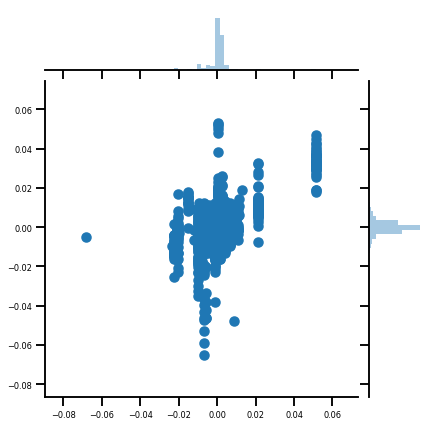

In [414]:
sns.jointplot(x_projected[:, 2],
              y_projected[:, 2],
             )

In [415]:
sns.set_context('talk', font_scale=0.5)
current_palette = sns.color_palette()
sign_lut = {-1: current_palette[3],
             1: current_palette[0]}


In [416]:
to_plot_x

,Metric,Weight,sign
3,clean_receive_channels,0.001689,1.0
0,bids_meta.FlipAngle,0.001917,1.0
1,bids_meta.RepetitionTime,0.002122,1.0
2,bids_meta.EchoTime,0.006192,1.0


In [417]:
hoX_names

array(['bids_meta.FlipAngle', 'bids_meta.RepetitionTime',
       'bids_meta.EchoTime', 'clean_receive_channels'], dtype='<U24')

In [418]:
x_weights[:, ci]

array([-6.44577541e-03,  3.34602394e-05, -5.86495401e-05, -2.86279510e-04])

In [419]:
list(zip(hoX_names, x_weights[:, ci]))

[('bids_meta.FlipAngle', -0.006445775406865821),
 ('bids_meta.RepetitionTime', 3.346023935246057e-05),
 ('bids_meta.EchoTime', -5.864954011250997e-05),
 ('clean_receive_channels', -0.00028627951023938385)]

In [420]:
pd.DataFrame(list(zip(hoX_names, x_weights[:, ci])), columns=['Metric', 'Weight'])

,Metric,Weight
0,bids_meta.FlipAngle,-0.006446
1,bids_meta.RepetitionTime,0.000033
2,bids_meta.EchoTime,-0.000059
3,clean_receive_channels,-0.000286


In [421]:
to_plot_x = pd.DataFrame(list(zip(hoX_names, x_weights[:, ci])), columns=['Metric', 'Weight']).sort_values('Weight')

In [422]:
ci = 0
thresh = 0.005
to_plot_x = pd.DataFrame(list(zip(hoX_names, x_weights[:, ci])), columns=['Metric', 'Weight']).sort_values('Weight')
to_plot_y = pd.DataFrame(list(zip(hoY_names, y_weights[:, ci])), columns=['Metric', 'Weight']).sort_values('Weight')

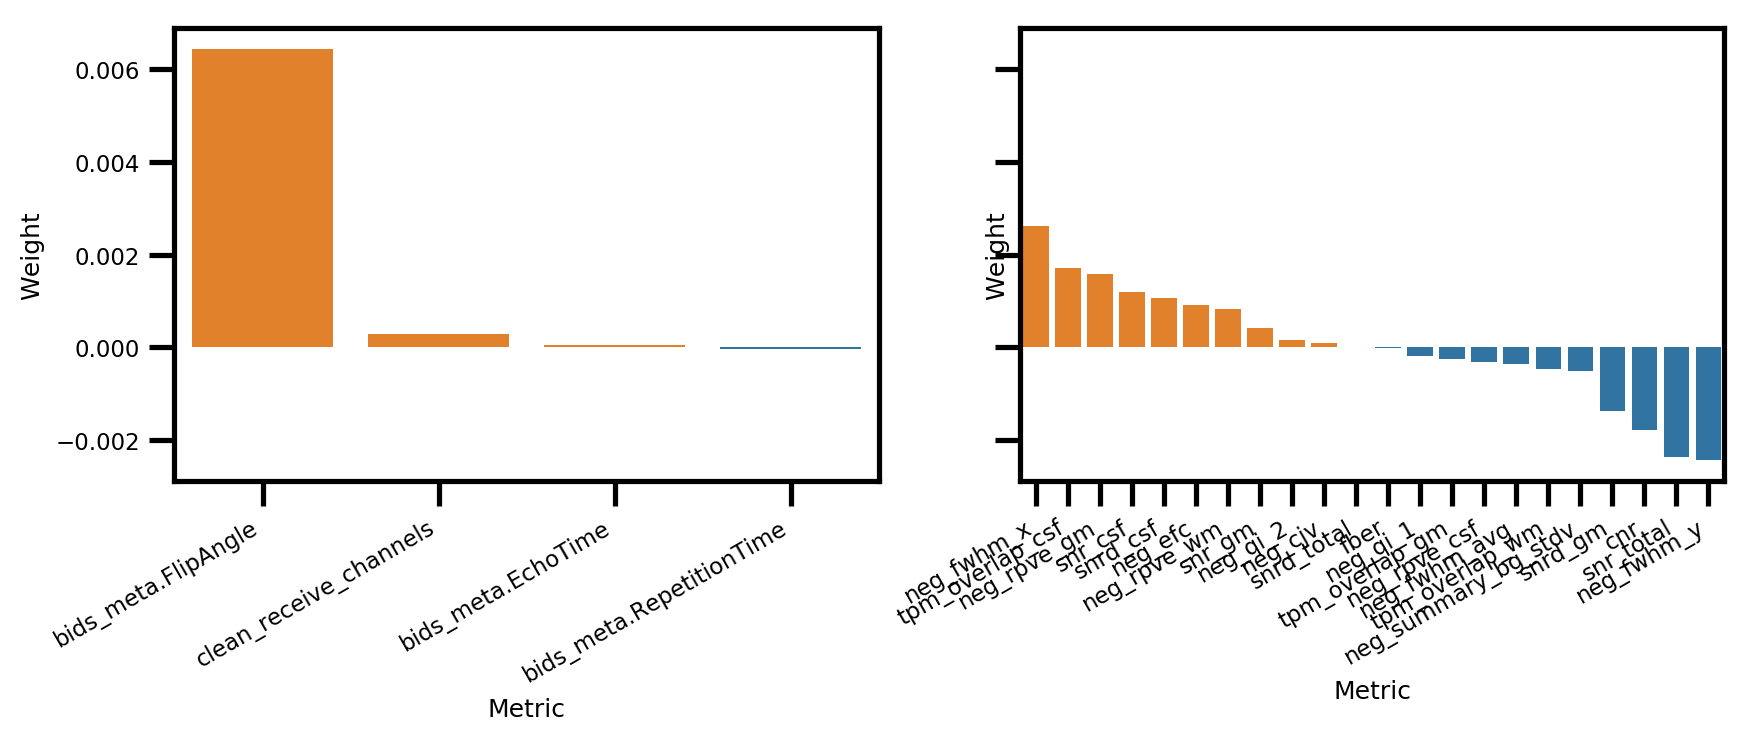

In [486]:
ci = 0
thresh = 0.00
to_plot_x = pd.DataFrame(list(zip(hoX_names, -x_weights[:, ci])), columns=['Metric', 'Weight']).sort_values('Weight', ascending = False)
to_plot_y = pd.DataFrame(list(zip(hoY_names, -y_weights[:, ci])), columns=['Metric', 'Weight']).sort_values('Weight', ascending = False)

to_plot_x['sign'] = np.sign(to_plot_x.Weight)
to_plot_y['sign'] = np.sign(to_plot_y.Weight)

to_plot_x = to_plot_x[np.abs(to_plot_x.Weight) > thresh]
to_plot_y = to_plot_y[np.abs(to_plot_y.Weight) > thresh]


fig,axs = plt.subplots(1, 2, figsize=(10, 3), dpi=200, sharey=True)
#sns.barplot(x='Metric', y='Weight', data=to_plot_x, hue='sign', hue_order = [-1,1], palette=sign_palette, dodge=False, ax=axs[0])
#sns.barplot(x='Metric', y='Weight', data=to_plot_y, hue='sign', hue_order = [-1,1], palette=sign_palette, dodge=False, ax=axs[1])
sns.barplot(x='Metric', y='Weight', data=to_plot_x, hue='sign', hue_order = [-1,1], dodge=False, ax=axs[0])
sns.barplot(x='Metric', y='Weight', data=to_plot_y, hue='sign', hue_order = [-1,1], dodge=False, ax=axs[1])

for ax in axs:
    ax.get_legend().remove()
    labels = ax.get_xticklabels()
    for i,label in enumerate(labels):
        label.set_ha('right')
    ax.xaxis.set_tick_params(rotation=30)

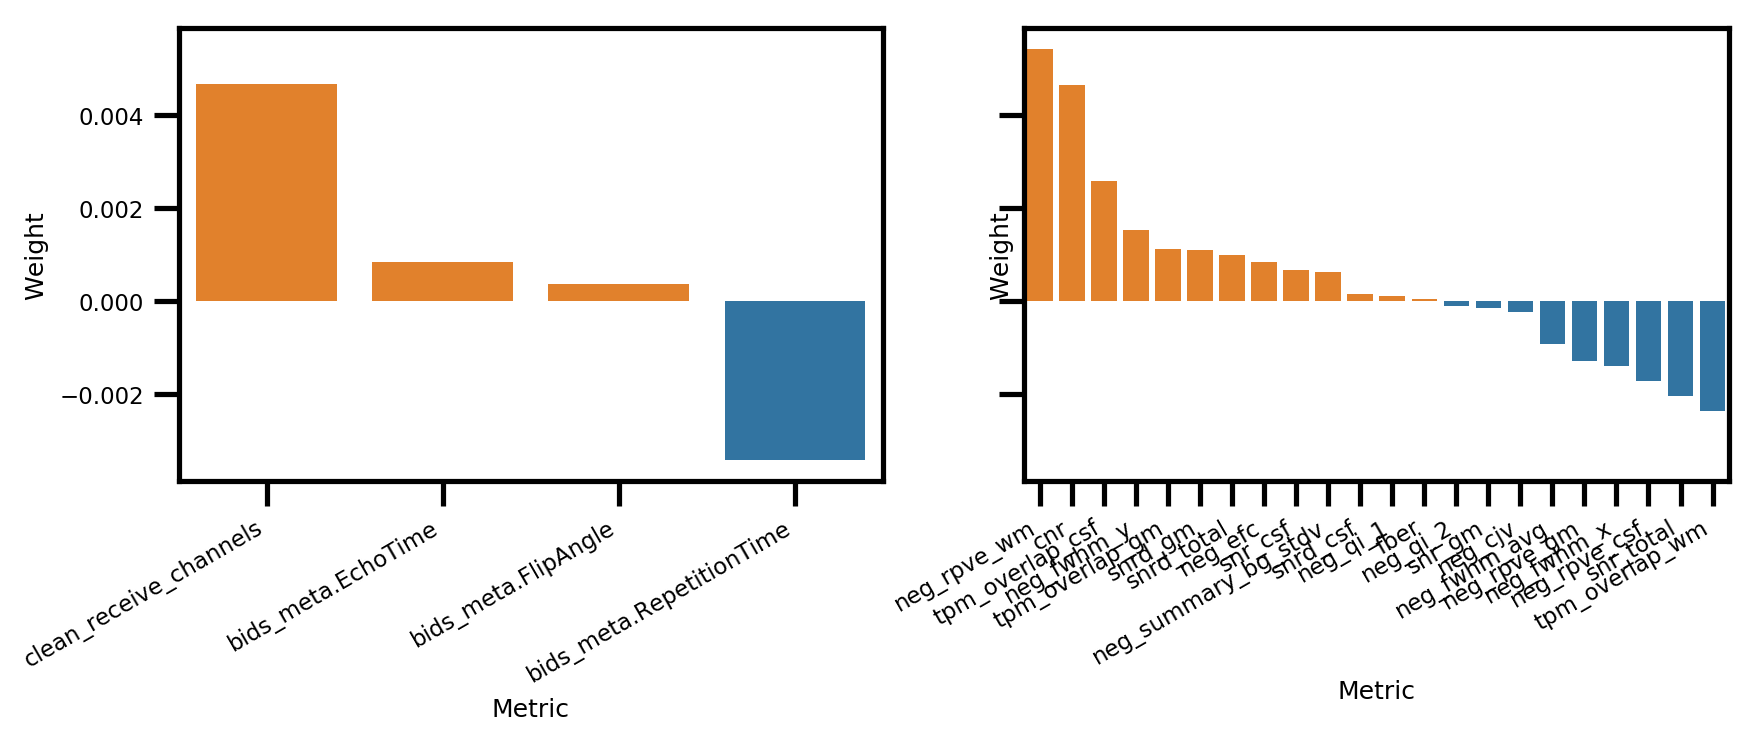

In [487]:
ci = 1
thresh = 0.00
to_plot_x = pd.DataFrame(list(zip(hoX_names, -x_weights[:, ci])), columns=['Metric', 'Weight']).sort_values('Weight', ascending = False)
to_plot_y = pd.DataFrame(list(zip(hoY_names, -y_weights[:, ci])), columns=['Metric', 'Weight']).sort_values('Weight', ascending = False)

to_plot_x['sign'] = np.sign(to_plot_x.Weight)
to_plot_y['sign'] = np.sign(to_plot_y.Weight)

to_plot_x = to_plot_x[np.abs(to_plot_x.Weight) > thresh]
to_plot_y = to_plot_y[np.abs(to_plot_y.Weight) > thresh]


fig,axs = plt.subplots(1, 2, figsize=(10, 3), dpi=200, sharey=True)
#sns.barplot(x='Metric', y='Weight', data=to_plot_x, hue='sign', hue_order = [-1,1], palette=sign_palette, dodge=False, ax=axs[0])
#sns.barplot(x='Metric', y='Weight', data=to_plot_y, hue='sign', hue_order = [-1,1], palette=sign_palette, dodge=False, ax=axs[1])
sns.barplot(x='Metric', y='Weight', data=to_plot_x, hue='sign', hue_order = [-1,1], dodge=False, ax=axs[0])
sns.barplot(x='Metric', y='Weight', data=to_plot_y, hue='sign', hue_order = [-1,1], dodge=False, ax=axs[1])

for ax in axs:
    ax.get_legend().remove()
    labels = ax.get_xticklabels()
    for i,label in enumerate(labels):
        label.set_ha('right')
    ax.xaxis.set_tick_params(rotation=30)

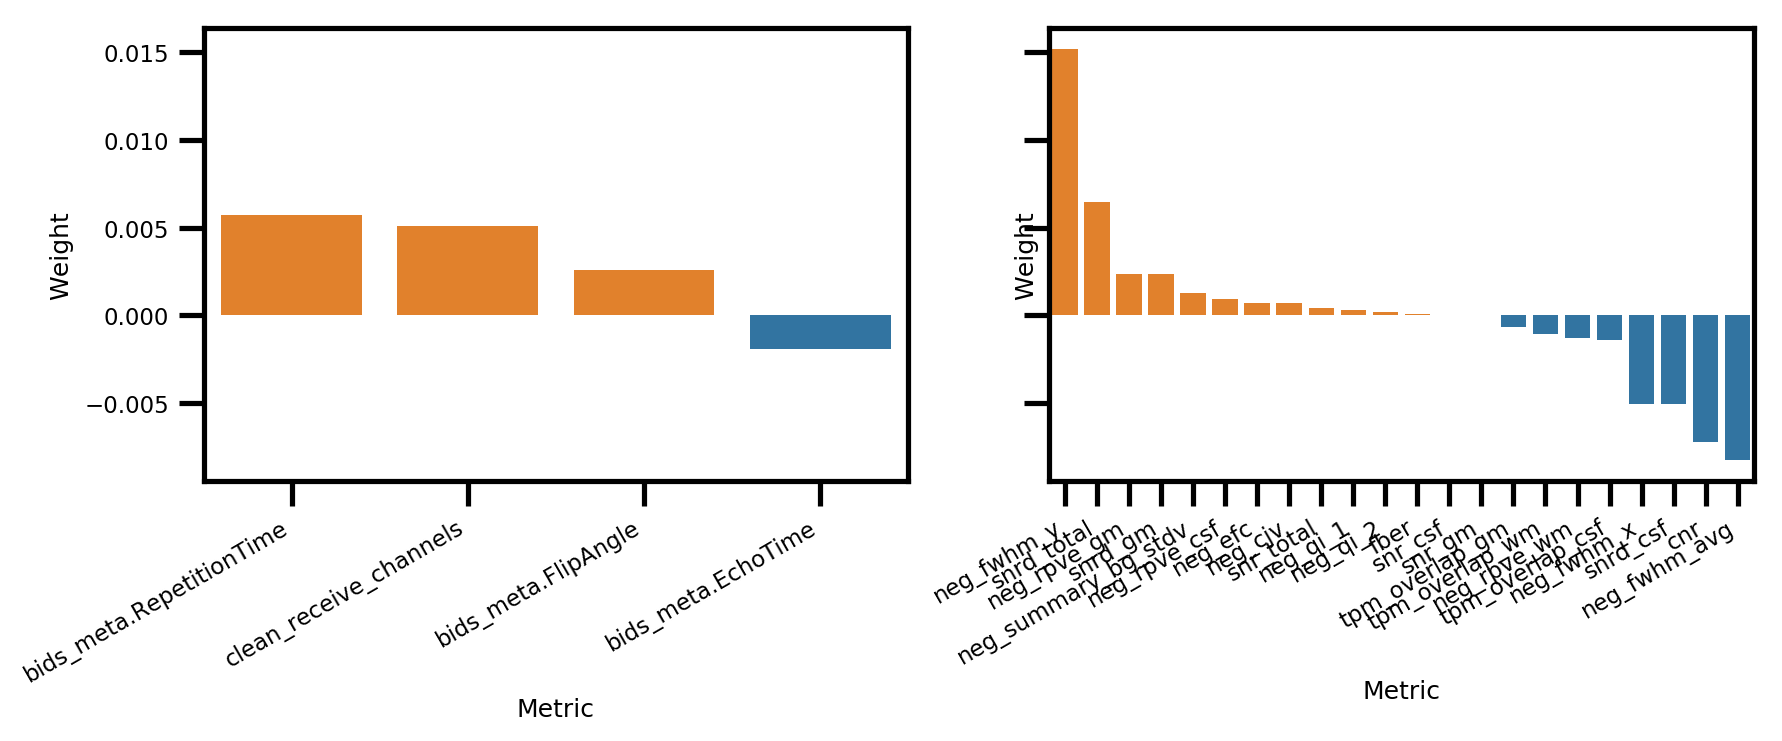

In [488]:
ci = 2
thresh = 0.00
to_plot_x = pd.DataFrame(list(zip(hoX_names, -x_weights[:, ci])), columns=['Metric', 'Weight']).sort_values('Weight', ascending = False)
to_plot_y = pd.DataFrame(list(zip(hoY_names, -y_weights[:, ci])), columns=['Metric', 'Weight']).sort_values('Weight', ascending = False)

to_plot_x['sign'] = np.sign(to_plot_x.Weight)
to_plot_y['sign'] = np.sign(to_plot_y.Weight)

to_plot_x = to_plot_x[np.abs(to_plot_x.Weight) > thresh]
to_plot_y = to_plot_y[np.abs(to_plot_y.Weight) > thresh]


fig,axs = plt.subplots(1, 2, figsize=(10, 3), dpi=200, sharey=True)
#sns.barplot(x='Metric', y='Weight', data=to_plot_x, hue='sign', hue_order = [-1,1], palette=sign_palette, dodge=False, ax=axs[0])
#sns.barplot(x='Metric', y='Weight', data=to_plot_y, hue='sign', hue_order = [-1,1], palette=sign_palette, dodge=False, ax=axs[1])
sns.barplot(x='Metric', y='Weight', data=to_plot_x, hue='sign', hue_order = [-1,1], dodge=False, ax=axs[0])
sns.barplot(x='Metric', y='Weight', data=to_plot_y, hue='sign', hue_order = [-1,1], dodge=False, ax=axs[1])

for ax in axs:
    ax.get_legend().remove()
    labels = ax.get_xticklabels()
    for i,label in enumerate(labels):
        label.set_ha('right')
    ax.xaxis.set_tick_params(rotation=30)

In [426]:
def plot_val(val, names, xlim=None):
    held_out_preds = pd.DataFrame(list(zip(names, val)), columns=['Metric', 'Accuracy']).sort_values('Accuracy')
    held_out_preds['sign'] = np.sign(held_out_preds.Accuracy)

    sign_palette = [sign_lut[ss] for ss in np.unique(held_out_preds.sign)]
    fig,ax = plt.subplots(1, 1, figsize=(3,10/65.*len(names)), dpi=200)
    sns.barplot(x='Accuracy', y='Metric', data=held_out_preds, hue='sign', hue_order = [-1,1], palette=sign_palette, dodge=False)
    sns.despine(fig)
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.get_legend().remove()

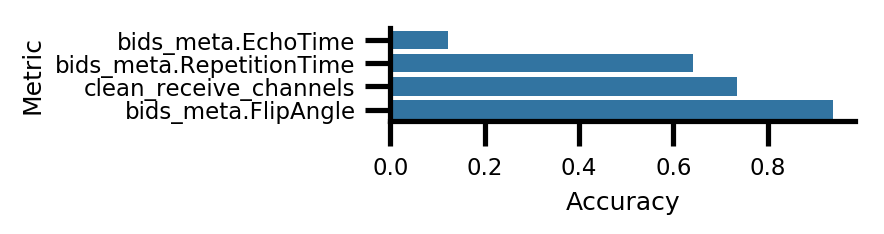

In [427]:
plot_val(hoX_pred, hoX_names)

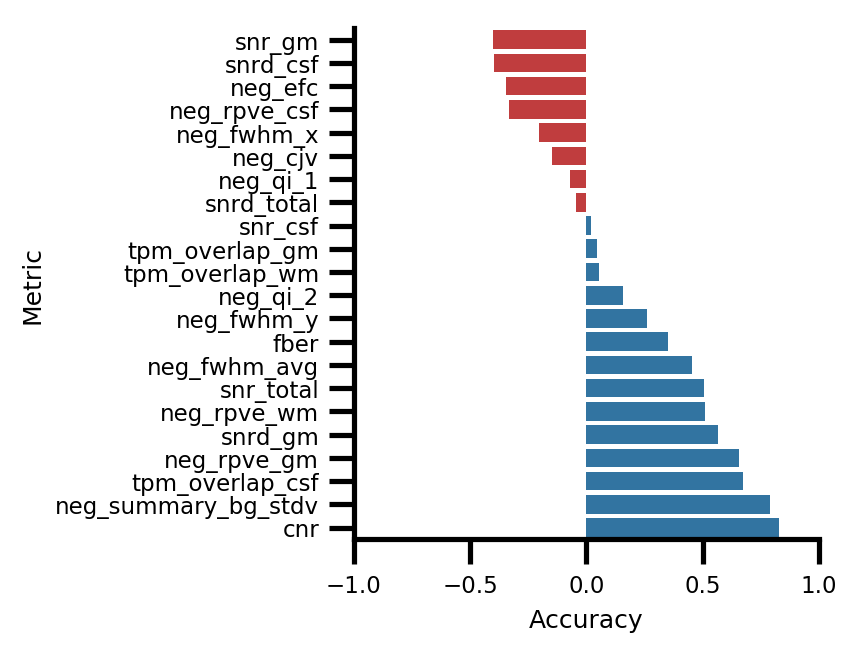

In [428]:
plot_val(hoY_pred, hoY_names, xlim=(-1,1))

In [429]:
hoY.shape

(5241, 22)

In [430]:
wY.shape

(12231, 22)

In [431]:
hoY_names

array(['cnr', 'fber', 'snr_csf', 'snr_gm', 'snr_total', 'snrd_csf',
       'snrd_gm', 'snrd_total', 'tpm_overlap_csf', 'tpm_overlap_gm',
       'tpm_overlap_wm', 'neg_cjv', 'neg_efc', 'neg_fwhm_avg',
       'neg_fwhm_x', 'neg_fwhm_y', 'neg_qi_1', 'neg_qi_2', 'neg_rpve_csf',
       'neg_rpve_gm', 'neg_rpve_wm', 'neg_summary_bg_stdv'], dtype='<U19')

# Regression

In [432]:
def reg_coef(X, Y):
    return np.linalg.solve(np.dot(X.T, X), np.dot(X.T, Y))

In [434]:
np.mean(X, 0)

array([ 3.57874089e-16,  4.48155961e-16,  5.04277125e-17, -2.59255377e-17])

In [435]:
B_xy = reg_coef(wX, wY)
pred_Y = np.dot(hoX, B_xy)
B_yx = reg_coef(wY, wX)
pred_X = np.dot(hoY, B_yx)

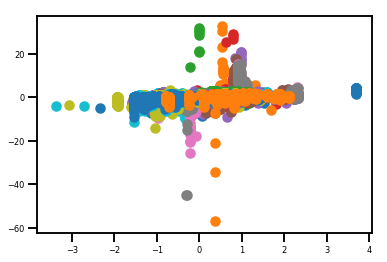

In [440]:
for i in range(hoY.shape[1]):
    plt.scatter(pred_Y[:, i], hoY[:, i])

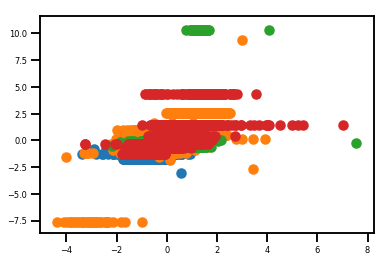

In [441]:
for i in range(hoX.shape[1]):
    plt.scatter(pred_X[:, i], hoX[:, i])

In [445]:
import scipy as sp
ycors = np.array([sp.stats.pearsonr(hoY[:, i], pred_Y[:, i])[0] for i in range(hoY.shape[1])])
xcors = np.array([sp.stats.pearsonr(hoX[:, i], pred_X[:, i])[0] for i in range(hoX.shape[1])])


In [448]:
list(zip(Y_names, ycors))

[('cnr', 0.8545810726568799),
 ('fber', 0.3656014624522952),
 ('snr_csf', 0.07044670689932699),
 ('snr_gm', 0.42023522906105615),
 ('snr_total', 0.615444155376391),
 ('snr_wm', 0.5751884157604498),
 ('snrd_csf', 0.6510533713985182),
 ('snrd_gm', 0.652745567699971),
 ('snrd_total', 0.7028573245669899),
 ('snrd_wm', 0.5252240488451854),
 ('tpm_overlap_csf', 0.16202364009408285),
 ('tpm_overlap_gm', 0.15557668239462788),
 ('tpm_overlap_wm', 0.4500804635813403),
 ('neg_cjv', 0.533796861097437),
 ('neg_efc', 0.4572387678041057),
 ('neg_fwhm_avg', 0.5786391828774291),
 ('neg_fwhm_x', 0.12285030543337966),
 ('neg_fwhm_y', 0.18603273607997436),
 ('neg_fwhm_z', 0.6413739723585163),
 ('neg_qi_1', 0.7811735212983685),
 ('neg_qi_2', 0.7783793456876327),
 ('neg_rpve_csf', 0.7945956435333353)]

In [449]:
list(zip(X_names, xcors))

[('bids_meta.FlipAngle', 0.9408477294166365),
 ('bids_meta.RepetitionTime', 0.7030736340825302),
 ('bids_meta.EchoTime', 0.35462703976432963),
 ('clean_receive_channels', 0.7572323113622986)]

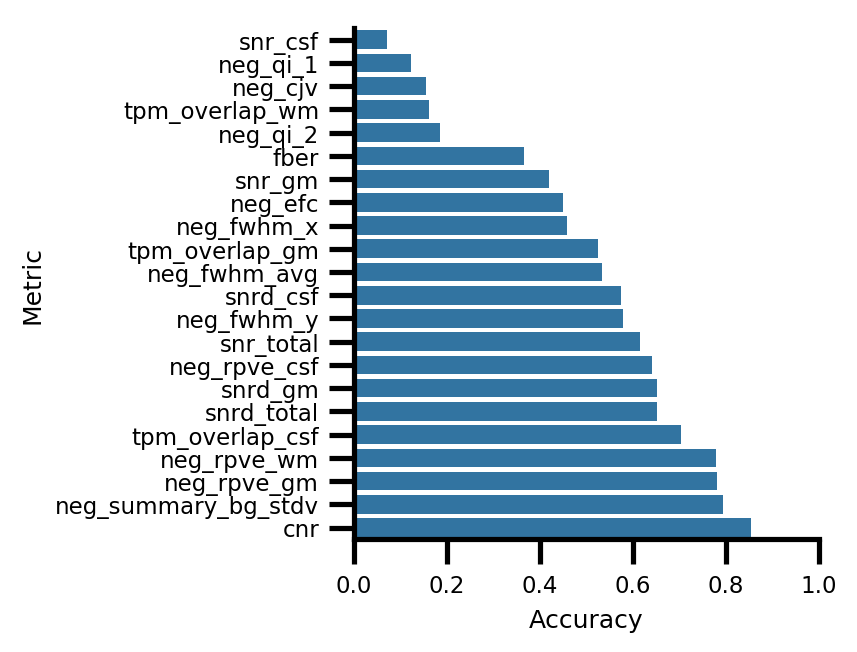

In [453]:

plot_val(ycors, hoY_names, xlim=(0,1))

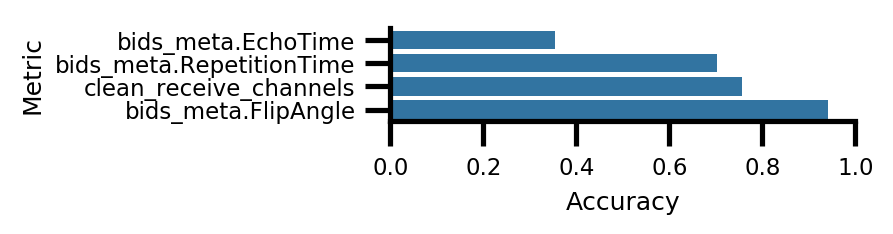

In [454]:
plot_val(xcors, hoX_names, xlim=(0,1))

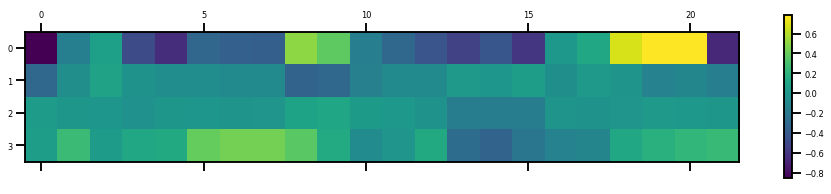

In [460]:
plt.matshow(B_xy)
plt.colorbar()

In [458]:
X_names

array(['bids_meta.FlipAngle', 'bids_meta.RepetitionTime',
       'bids_meta.EchoTime', 'clean_receive_channels'], dtype='<U24')

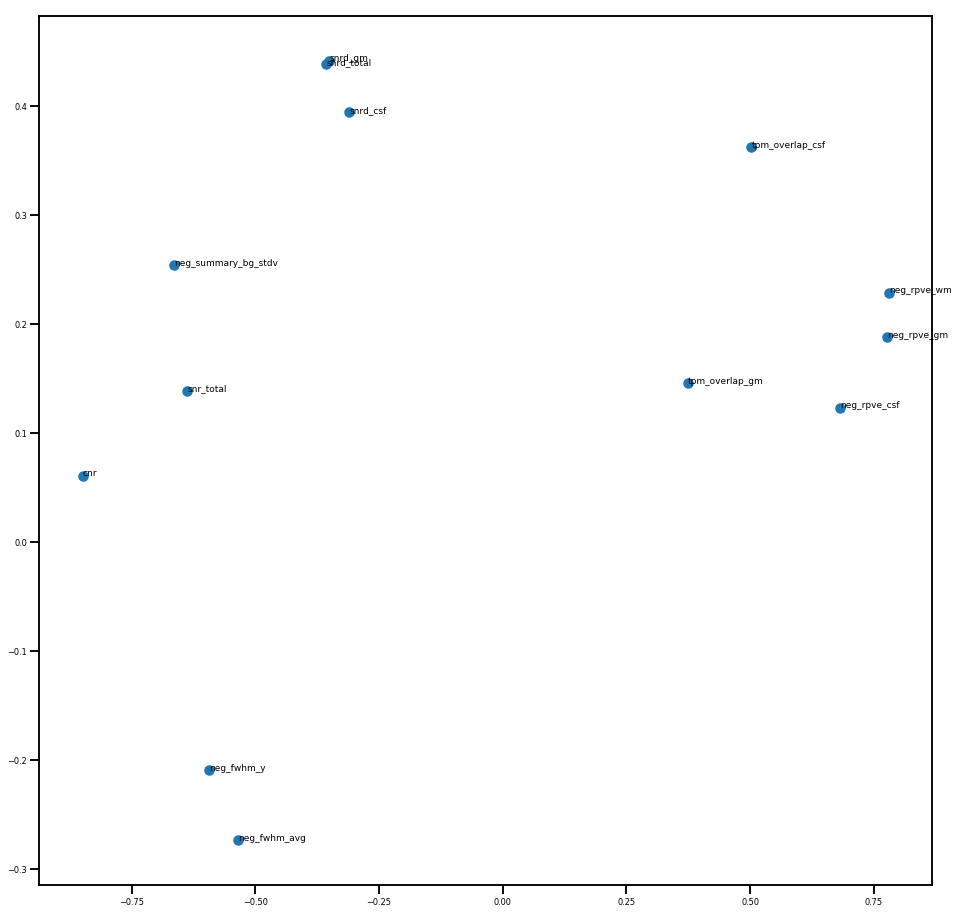

In [469]:
filt = ycors > 0.5

xvar = B_xy[0, filt]
yvar = B_xy[3, filt]
names = hoY_names[filt]
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.scatter(xvar, yvar)
for label, x, y in zip(names, xvar, yvar):
    ax.text(x,y,label)

In [478]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(wY.T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [479]:
cdsY = pca.fit_transform(wY.T)

In [480]:
cdsY.shape

(22, 2)

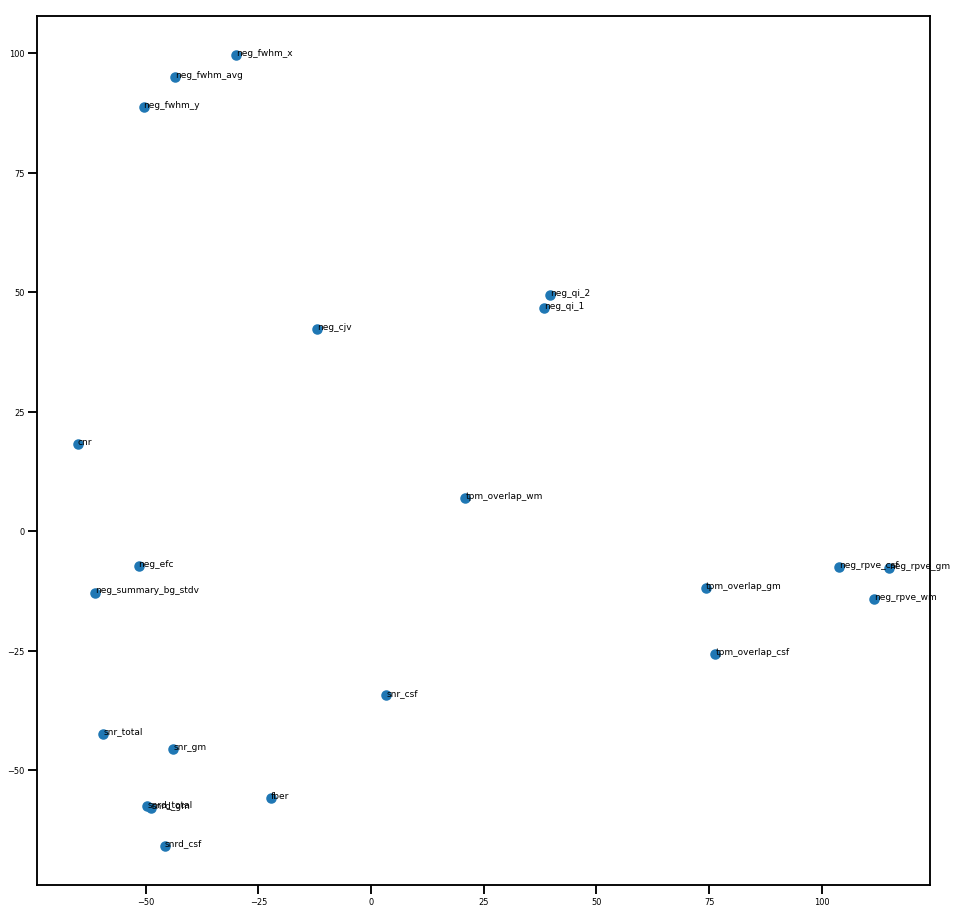

In [481]:
xvar = cdsY[:,0]
yvar = cdsY[:,1]
names = hoY_names
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.scatter(xvar, yvar)
for label, x, y in zip(names, xvar, yvar):
    ax.text(x,y,label)